In [11]:
import warnings

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplfinance as mpf

from yahoo_fin_api import load_df
from fin_viz import candlechart
from traditional_denoising import moving_avg, exp_moving_avg, bilateral_filter

%matplotlib inline
warnings.filterwarnings(action='ignore')

In [2]:
df = load_df('snp.csv')
filtered = bilateral_filter(df['Mean'], window=5, sigma_d=150, sigma_i=30)

<Figure size 2000x300 with 0 Axes>

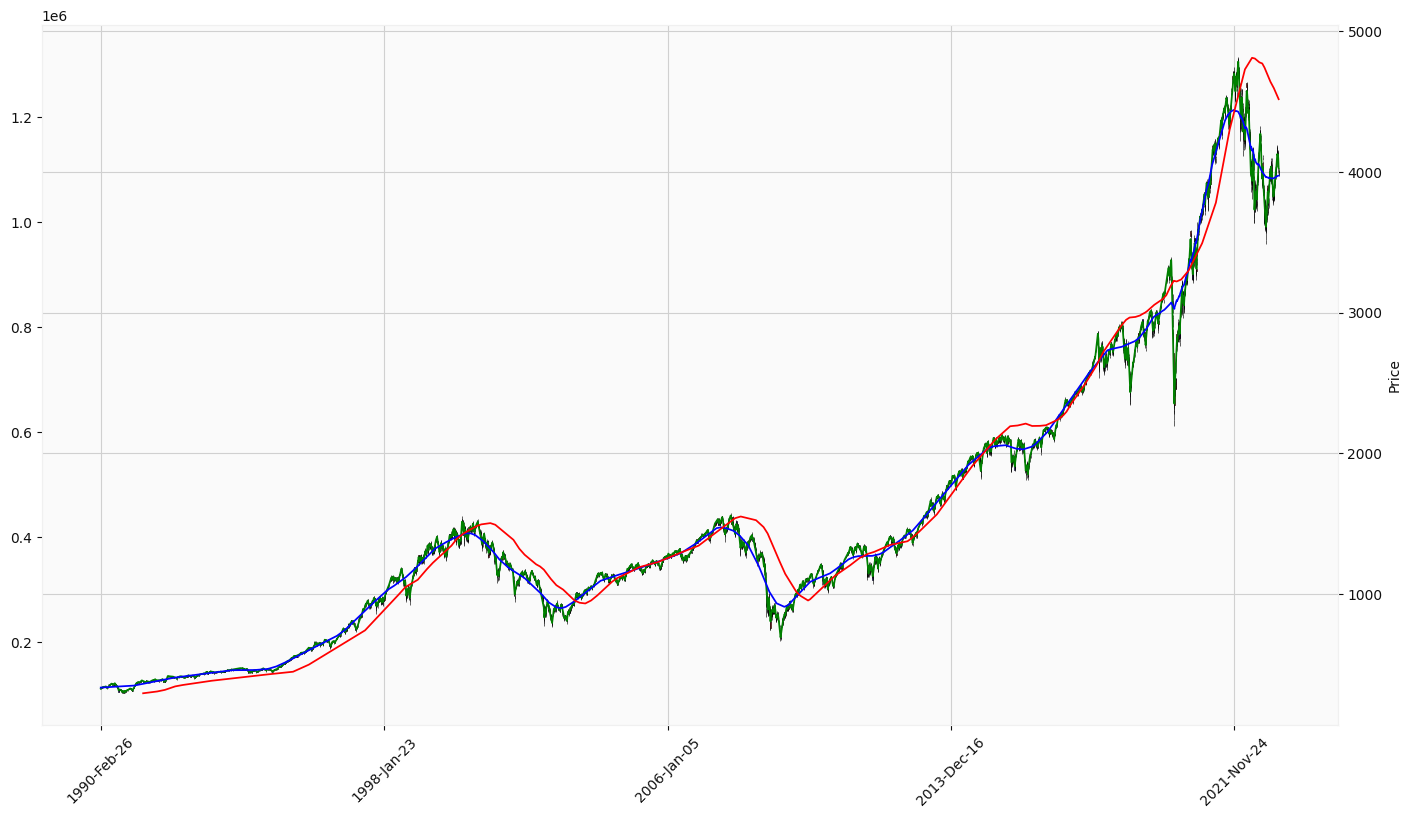

In [14]:
plt.figure(figsize=(20, 3))
ma_filtered = moving_avg(df['Mean'], window=300)
ema_filtered = exp_moving_avg(df['Mean'], alpha=.4, adjust=False)
bilateral_filtered = bilateral_filter(df['Mean'], window=301, sigma_d=100, sigma_i=1000)

bilateral_filtered = pd.Series(bilateral_filtered, index=df.index)

apdict = [
    mpf.make_addplot(ma_filtered, type='line', color='r'),
    mpf.make_addplot(ema_filtered, type='line', color='g'),
    mpf.make_addplot(bilateral_filtered, type='line', color='b'),
]

fig, ax = candlechart(df, addplot=apdict)
fig.set_size_inches(18, 10)